# Распознавание эмоций


# Цель исследования

Построить модель распозвавания (классификации) эмоций по изображению лица. Максимизировать метрику Accuracy.

# Описание данных

Данные взяты из открытого источника с сайта [kaggle](https://www.kaggle.com/datasets/noamsegal/affectnet-training-data). Датасет AffectNet — это большая база данных лиц, помеченных «аффектами» (психологический термин для обозначения выражений лица). Чтобы учесть общие ограничения памяти, разрешение было уменьшено до 96x96. Это означает, что все изображения имеют размер ровно 96x96 пикселей.

# Этапы исследования
1. Обзор данных
2. Подготовка данных и обучение моделей

## Обзор данных

In [1]:
# подключимся к гугл-диску

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# разархивируем датасет с изображениями

!unzip gdrive/My\ Drive/Эмоции/affectnet.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: sad/image0025659.jpg    
  inflating: sad/image0025666.jpg    
  inflating: sad/image0025673.jpg    
  inflating: sad/image0025679.jpg    
  inflating: sad/image0025681.jpg    
  inflating: sad/image0025693.jpg    
  inflating: sad/image0025694.jpg    
  inflating: sad/image0025697.jpg    
  inflating: sad/image0025715.jpg    
  inflating: sad/image0025725.jpg    
  inflating: sad/image0025726.jpg    
  inflating: sad/image0025730.jpg    
  inflating: sad/image0025736.jpg    
  inflating: sad/image0025753.jpg    
  inflating: sad/image0025760.jpg    
  inflating: sad/image0025761.jpg    
  inflating: sad/image0025769.jpg    
  inflating: sad/image0025774.jpg    
  inflating: sad/image0025787.jpg    
  inflating: sad/image0025808.jpg    
  inflating: sad/image0025822.jpg    
  inflating: sad/image0025834.jpg    
  inflating: sad/image0025835.jpg    
  inflating: sad/image0025843.jpg    
  inflating: sad/ima

In [3]:
# импортируем нужные библиотеки

import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from PIL import Image
import keras
from keras.utils import to_categorical
import os
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPool2D
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from IPython.display import Image
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback
import warnings
warnings.filterwarnings("ignore")

In [4]:
# создадим путь до папки с изображениями

dir = Path("emotions")

In [5]:
# сохраним таблицу с метками эмоций и путями до изображений в переменную labels

labels = pd.read_csv('/content/gdrive/MyDrive/Эмоции/labels_affectnet.csv')

In [6]:
# удалим ненужный столбец

labels.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
# выведем первые 5 строк

labels.head()

,pth,label
0,anger/image0000006.jpg,surprise
1,anger/image0000060.jpg,anger
2,anger/image0000061.jpg,anger
3,anger/image0000066.jpg,disgust
4,anger/image0000106.jpg,anger


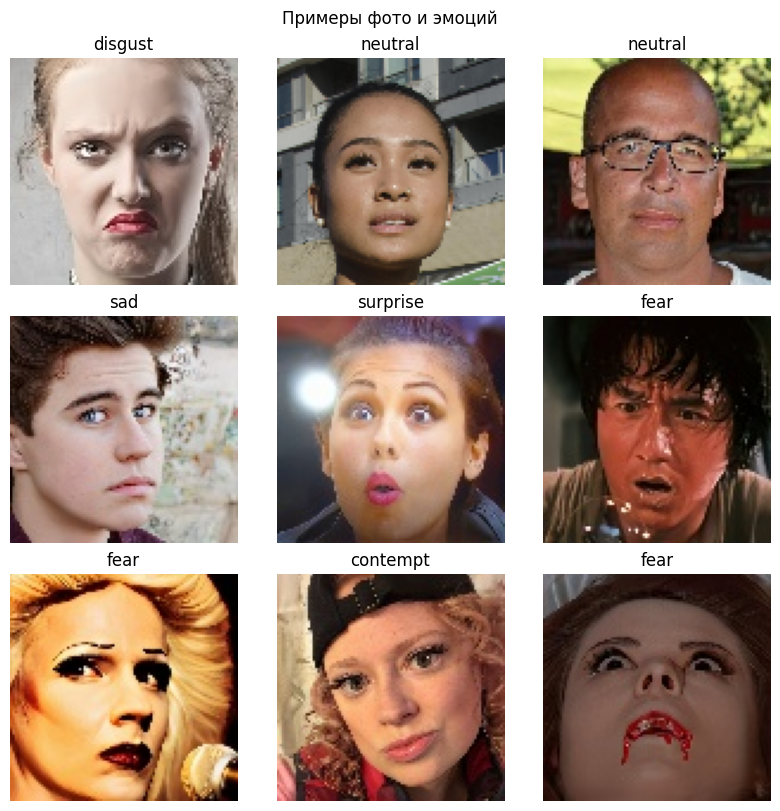

In [ ]:
# выведем 9 случайных изображений с метками эмоций

fig, axs = plt.subplots(3, 3, sharey=True, constrained_layout=True,\
                        num=None, figsize=(8, 8), dpi=100, edgecolor='k')
fig.suptitle('Примеры фото и эмоций')
axs = axs.flatten()

for i in range(9):
    idx = random.randint(0, len(labels)-1)
    image = cv2.imread('emotions/' + labels['pth'][idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (96, 96))
    axs[i].imshow(image)
    axs[i].set_title(labels['label'][idx])
    axs[i].axis('off')

С изображениями все хорошо, метки классов соответствуют эмоциям. Можем двигаться дальше.

**Вывод**

Подготовили путь до папки с изображениями. Убедились, что метки классов соответсвуют эмоциями на изображниях.

## Подготовка данных и обучение моделей

Дальнейшая логика будет следующей. Попробуем обучить модели нейронных сетей сконструированных вручную, а также готовые предобученные модели для работы с изображениями (VGG19, DenseNet121/169/201 и ResNet50). Для этого напишем функции для подготовки выборок, а также для обучения и оценки качества моделей. Начнем с ручных моделей.

### Подготовка данных для ручных моделей

In [7]:
# подготовим отдельный список с названиями эмоций

emotions = list(labels['label'].unique())
emotions = [f.name for f in os.scandir(dir) if f.is_dir()]
emotions

['disgust', 'fear', 'neutral', 'anger', 'happy', 'sad', 'surprise', 'contempt']

Напишем функции для разделения выборки на признаки и целевой признак. А также разделим подготовленные данные на тренировочную и валидационную выборки.

In [8]:
image_size = (96, 96)

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y))
    return X, y

X, y = load_images(dir, emotions, image_size)

features_train, features_valid, target_train, target_valid =\
train_test_split(X, y, test_size=0.25, stratify=y, random_state=12345)

input_shape = features_train[0].shape
print(input_shape)
print(len(features_train))
print(len(features_valid))

(96, 96, 3)
21781
7261


Всего у нас получилось более 21к изображений в тренировочной выборке и более 7к - в валидационной.

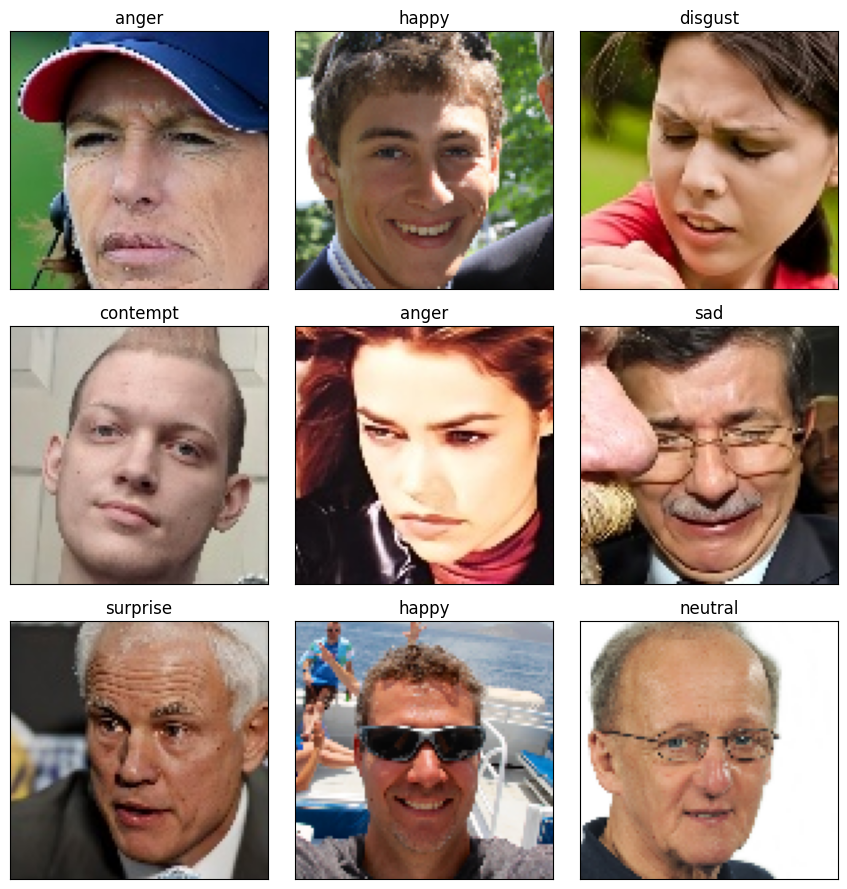

In [ ]:
# выведем 9 случайных изображений с метками эмоций тренировочной выборки

fig = plt.figure(figsize=(9,9))
for i in range(9):
    idx = random.randint(0, len(features_train))
    fig.add_subplot(3,3, i+1)
    plt.imshow(features_train[idx])
    plt.title(emotions[np.argmax(target_train[idx])])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

С подготовленной выборкой и изображениями все впорядке, можем двигаться дальше.

### Подготовка функций для создания и оценки ручных моделей

In [9]:
# функция инициализации ручной модели

def hand_model_init(activation, input_shape):

  model = Sequential()

  model.add(Conv2D(32, (3,3), activation=activation, input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3,3), activation=activation))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (3,3), activation=activation))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(256, (3,3), activation=activation))
  model.add(BatchNormalization())
  model.add(Conv2D(256, (3,3), activation=activation))
  model.add(BatchNormalization())
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation=activation, kernel_regularizer=l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(8, activation='softmax'))

  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy'])

  print("input shape ",model.input_shape)
  print("output shape ",model.output_shape)

  return model

In [10]:
# функция для обучения модели и вывода истории

def fit_history(batch_size, epochs, model):
  early_stopping = EarlyStopping(
      patience=10,
      monitor='val_loss',
      mode='min'),
  ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.5,
      patience=2,
      verbose=1),
  ModelCheckpoint(
      'best_model.h5',
      save_best_only=True,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max')

  history = model.fit(
      features_train, target_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(features_valid, target_valid),
      callbacks = [early_stopping],
      verbose=1)

  pd.DataFrame(history.history).plot();

  return model

In [11]:
# функция вывода classification_report и подготовки данных для матрицы ошибок

def class_rep(model):
  target_valid_int = np.argmax(target_valid, axis=1)
  predictions = model.predict(features_valid)
  predictions_int = np.argmax(predictions, axis=1)
  print('Accuracy', accuracy_score(target_valid_int, predictions_int))
  target_names = emotions
  print(classification_report(target_valid_int, predictions_int, target_names=target_names))

  return target_valid_int, predictions_int

In [12]:
# функция вывода матрицы ошибок

def conf_matrix(target_valid_int, predictions_int):
  fig = plt.figure(figsize=(13,10))
  ax= plt.subplot()
  sns.heatmap(confusion_matrix(target_valid_int, predictions_int, normalize='true'), annot=True, fmt='.0%', ax=ax) # fmt='g'
  plt.title("Матрица ошибок")
  plt.ylabel('Реальные значения')
  plt.xlabel('Предсказанные значения')
  pl.show();

In [13]:
# функция, собирающая воедино весь процесс

def hand_model_report(activation, input_shape, batch_size, epochs):
  model = hand_model_init(activation, input_shape)
  model = fit_history(batch_size, epochs, model)
  target_valid_int, predictions_int = class_rep(model)
  conf_matrix(target_valid_int, predictions_int)

  return model

**Ручная архитектура с SELU**

Немного напомним, что характерно для функции активации SELU.

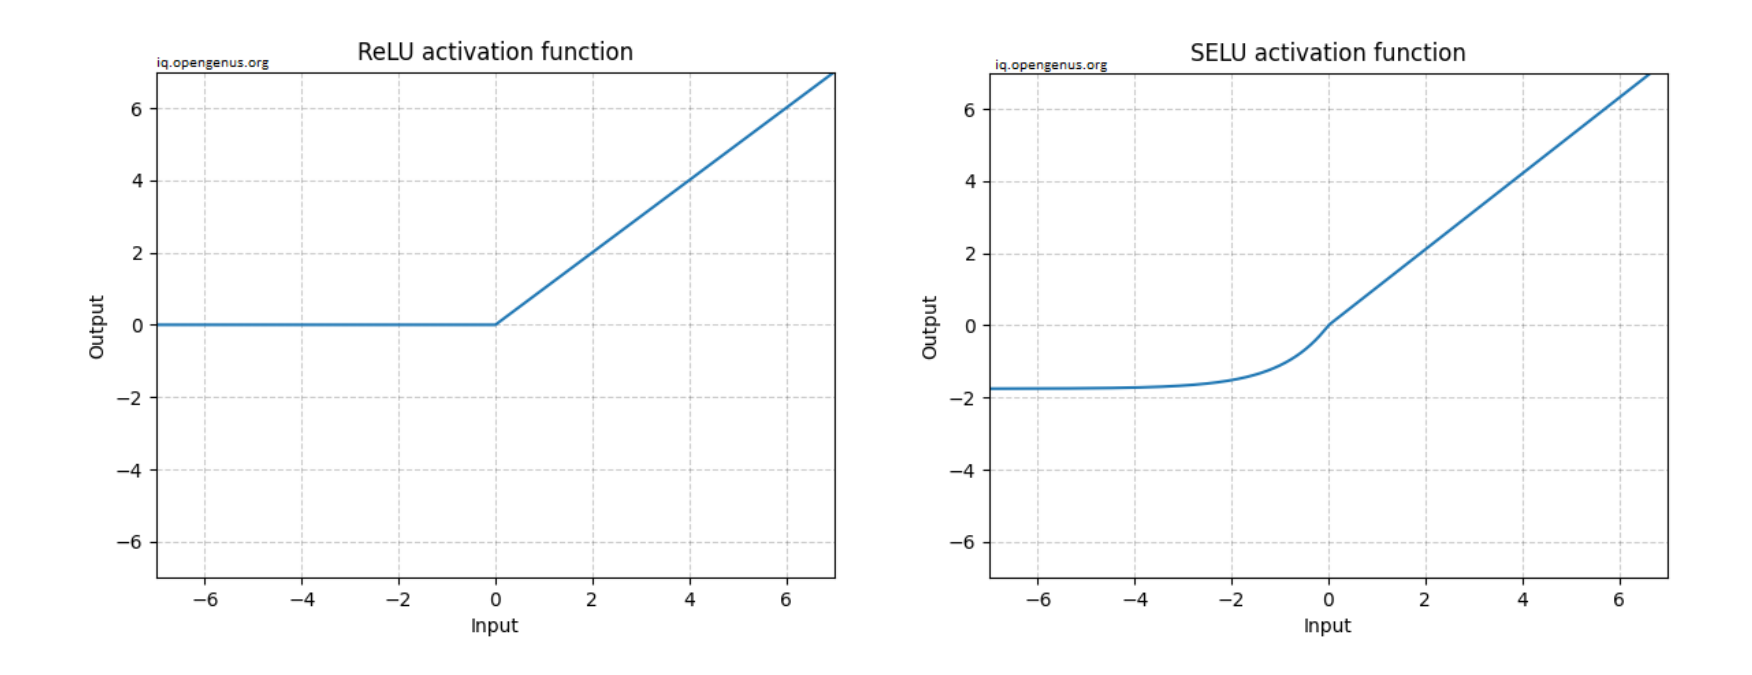

SELU (Scaled Exponential Linear Units), или масштабированные экспоненциальные линейные единицы, представляют собой функции активации, вызывающие самонормализацию. Активации нейронов сети SELU автоматически сходятся к нулевому среднему значению и единичной дисперсии.
https://iq.opengenus.org/scaled-exponential-linear-unit/

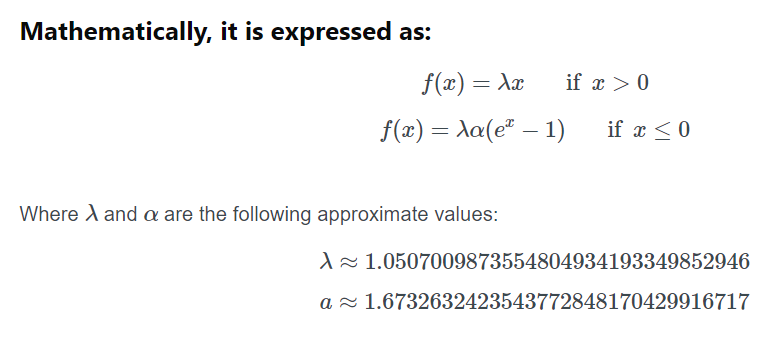

Обучим модель с функцией активации SELU на 25 эпохах.

input shape  (None, 96, 96, 3)
output shape  (None, 8)
Epoch 1/25
43/43 [==============================] - 26s 506ms/step - loss: 4.0246 - accuracy: 0.3396 - val_loss: 4.1923 - val_accuracy: 0.4439
Epoch 2/25
43/43 [==============================] - 20s 463ms/step - loss: 2.8098 - accuracy: 0.4580 - val_loss: 2.9581 - val_accuracy: 0.4608
Epoch 3/25
43/43 [==============================] - 21s 486ms/step - loss: 2.0947 - accuracy: 0.5204 - val_loss: 1.9641 - val_accuracy: 0.5452
Epoch 4/25
43/43 [==============================] - 21s 484ms/step - loss: 1.6633 - accuracy: 0.5589 - val_loss: 1.5330 - val_accuracy: 0.5724
Epoch 5/25
43/43 [==============================] - 20s 457ms/step - loss: 1.4052 - accuracy: 0.5821 - val_loss: 1.3171 - val_accuracy: 0.5888
Epoch 6/25
43/43 [==============================] - 20s 461ms/step - loss: 1.2534 - accuracy: 0.5996 - val_loss: 1.2182 - val_accuracy: 0.5868
Epoch 7/25
43/43 [==============================] - 20s 458ms/step - loss: 1.1350 - acc

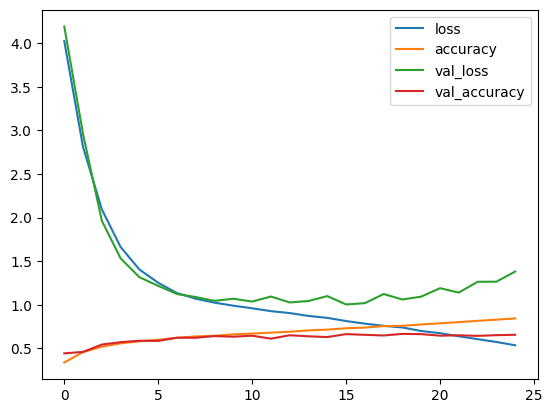

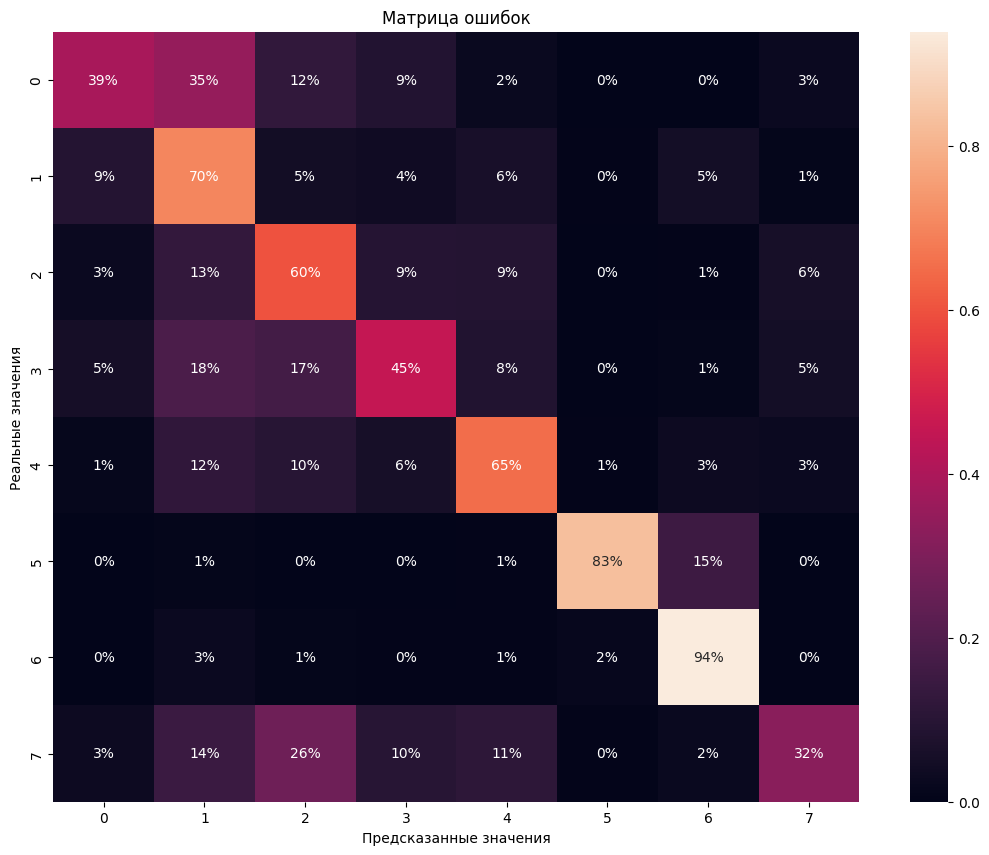

In [ ]:
model_25_selu = hand_model_report("selu", (96, 96, 3), 512, 25)

Удалось достигнуть точности 66% на валидации. Теперь попробуем другую функцию активации.

**Ручная архитектура с RELU**

Снова обучение на 25 эпохах, но теперь функция активации RELU.

input shape  (None, 96, 96, 3)
output shape  (None, 8)
Epoch 1/25
43/43 [==============================] - 43s 552ms/step - loss: 4.2149 - accuracy: 0.2766 - val_loss: 4.3113 - val_accuracy: 0.2578
Epoch 2/25
43/43 [==============================] - 17s 401ms/step - loss: 3.0433 - accuracy: 0.3971 - val_loss: 2.6825 - val_accuracy: 0.3765
Epoch 3/25
43/43 [==============================] - 18s 411ms/step - loss: 2.3410 - accuracy: 0.4694 - val_loss: 2.0228 - val_accuracy: 0.5108
Epoch 4/25
43/43 [==============================] - 18s 408ms/step - loss: 1.9078 - accuracy: 0.5098 - val_loss: 1.7125 - val_accuracy: 0.5294
Epoch 5/25
43/43 [==============================] - 18s 411ms/step - loss: 1.6026 - accuracy: 0.5433 - val_loss: 1.4712 - val_accuracy: 0.5532
Epoch 6/25
43/43 [==============================] - 18s 416ms/step - loss: 1.4147 - accuracy: 0.5670 - val_loss: 1.2861 - val_accuracy: 0.5838
Epoch 7/25
43/43 [==============================] - 18s 414ms/step - loss: 1.2844 - acc

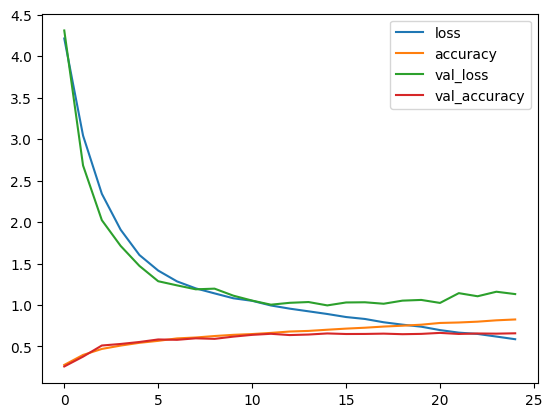

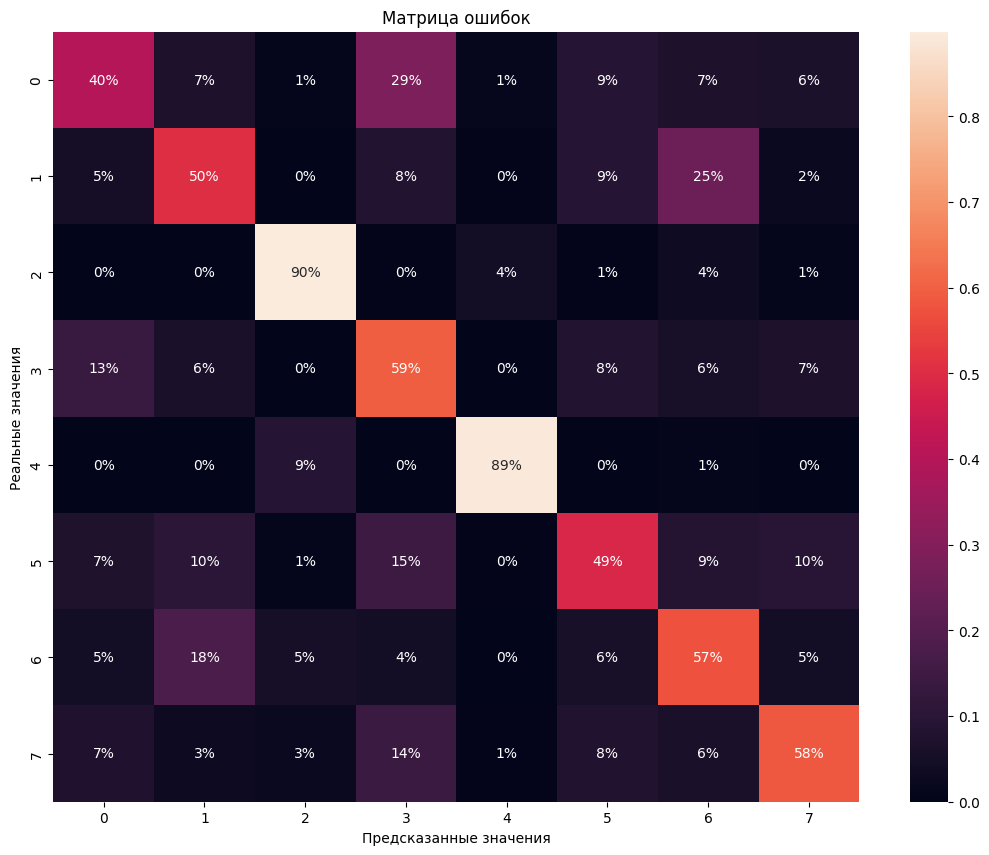

In [14]:
model_25_relu = hand_model_report("relu", (96, 96, 3), 512, 25)

Результат примерно такой же. Попробуем увеличить количество эпох для модели с функцией активации SELU.

**Ручная архитеркура с SELU 40 эпох**

Модель с функцией активации SELU, количество эпох увеличим до 40.

input shape  (None, 96, 96, 3)
output shape  (None, 8)
Epoch 1/40
43/43 [==============================] - 27s 500ms/step - loss: 4.0322 - accuracy: 0.3442 - val_loss: 7.3526 - val_accuracy: 0.2387
Epoch 2/40
43/43 [==============================] - 21s 491ms/step - loss: 2.7985 - accuracy: 0.4662 - val_loss: 2.7945 - val_accuracy: 0.4881
Epoch 3/40
43/43 [==============================] - 21s 485ms/step - loss: 2.0951 - accuracy: 0.5171 - val_loss: 1.8553 - val_accuracy: 0.5388
Epoch 4/40
43/43 [==============================] - 20s 455ms/step - loss: 1.6599 - accuracy: 0.5547 - val_loss: 1.4708 - val_accuracy: 0.5885
Epoch 5/40
43/43 [==============================] - 21s 486ms/step - loss: 1.4078 - accuracy: 0.5756 - val_loss: 1.3413 - val_accuracy: 0.5743
Epoch 6/40
43/43 [==============================] - 21s 486ms/step - loss: 1.2395 - accuracy: 0.5990 - val_loss: 1.1687 - val_accuracy: 0.6232
Epoch 7/40
43/43 [==============================] - 21s 486ms/step - loss: 1.1429 - acc

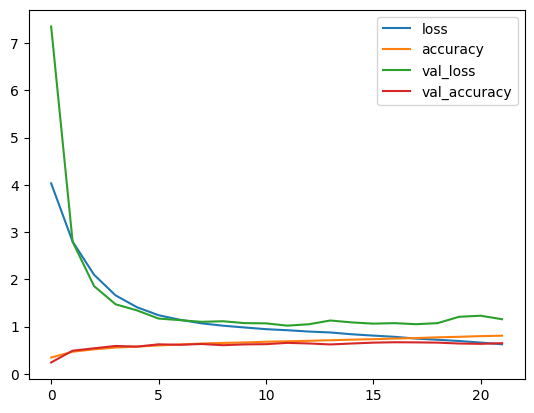

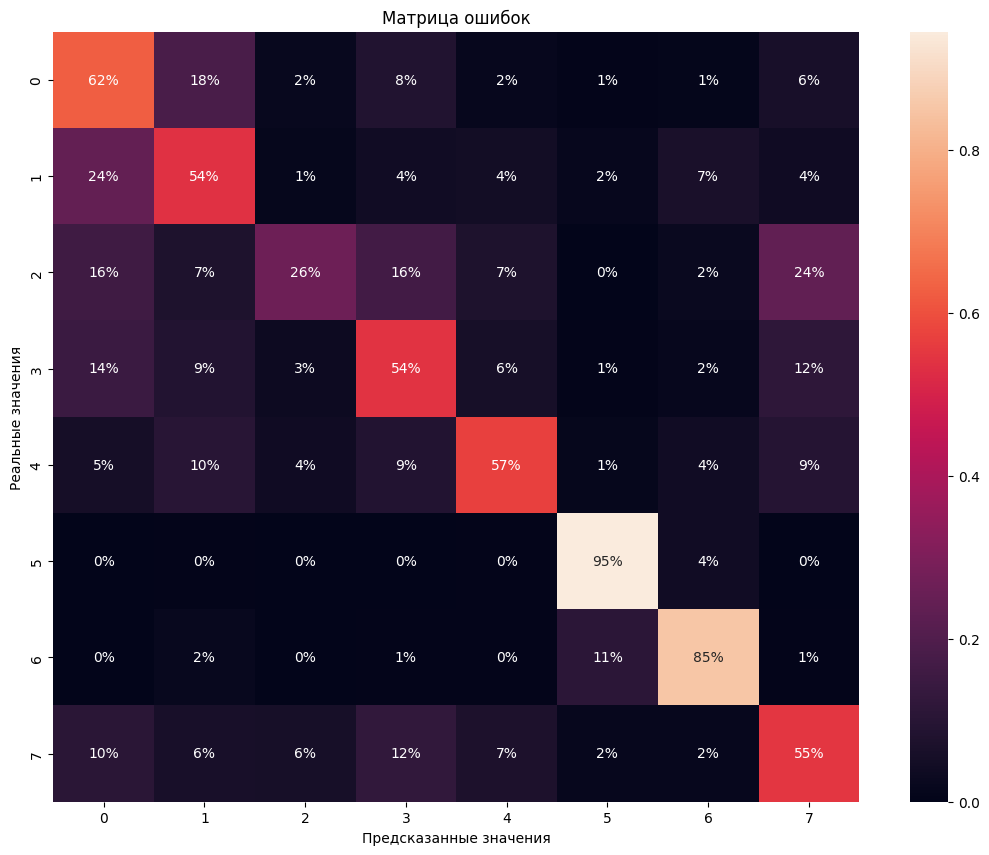

In [ ]:
model_40_selu = hand_model_report("selu", (96, 96, 3), 512, 40)

Увеличение количества эпох не улучшило ситуацию. Далее перейдем к готовым предобученных архитектурам.

### Использование предобученных моделей

**Подготовка фунции для загрузки данных**

Напишем функцию для загрузчика данных, которая также готовит тренировочную и валидационную выборки.

In [15]:
def data_gen(preprocess_input, batch_size, img_shape):

  image_gen = ImageDataGenerator(preprocessing_function=preprocess_input, # препроцессинг
                                validation_split=0.25, # размер валидационной выборки, так как всё берётся из одной папки
                                rotation_range=40,  # максимальный угол поворота
                                width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
                                height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
                                zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20%
                                horizontal_flip=True, # случайное отражение по горизонтали
                                fill_mode="nearest") # чем заполнять пробелы

  train_data_gen = image_gen.flow_from_directory(batch_size=batch_size, # размер батча
                                                directory=dir, # директория для доступа к изображениям
                                                shuffle=True, # перемешивать ли данные
                                                target_size=img_shape, # размер изображения
                                                class_mode="categorical", # тип классового распределения
                                                subset = "training") # указываем, что данная выборка тренировочная

  val_data_gen = image_gen.flow_from_directory(batch_size=batch_size,
                                              directory=dir,
                                              shuffle=False,
                                              target_size=img_shape,
                                              class_mode='categorical',
                                              subset = "validation") # указываем, что данная выборка валидационная

  features_train, target_train = next(train_data_gen)
  features_valid, target_valid = next(val_data_gen)
  input_shape = features_train[0].shape
  print(input_shape)

  return train_data_gen, val_data_gen, features_train, target_train, features_valid, target_valid

**Подготовка функций для создания и оценки предобученных моделей**

In [ ]:
# функция инициализации модели с указанием базовой предобученной нейросети

def model_init(base, activation, input_shape):

  base_model = base(input_shape=input_shape,
                                          include_top=False,
                                          weights='imagenet')
  base_model.trainable = True

  model = tf.keras.Sequential([base_model,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(512, activation=activation),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(8)])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  print("input shape ",model.input_shape)
  print("output shape ",model.output_shape)

  return model

In [ ]:
# функция обучения модели и вывода истории

def histoty_fit_generator(model, epochs):

  history = model.fit_generator(train_data_gen,
                                epochs=epochs,
                                validation_data=val_data_gen,
                                callbacks=[PlotLossesCallback()])
  return model

In [ ]:
# функция, собирающая воедино цинициализацию и обучение

def model_report(base, activation, input_shape, epochs):
  model = model_init(base, activation, input_shape)
  model = histoty_fit_generator(model, epochs)
  #target_valid_int, predictions_int = class_rep(model)
  #conf_matrix(target_valid_int, predictions_int)

  return model

Последовательно обучим и оценим модели VGG19, DenseNet121/169/201 и ResNet50.

#### VGG19

**Подготовка данных для VGG19**

In [16]:
# импортируем соответствующий предобработчик данных для VGG19
# готовим выборки для VGG19

from tensorflow.keras.applications.vgg19 import preprocess_input
train_data_gen, val_data_gen, features_train, target_train, features_valid, target_valid =\
data_gen(preprocess_input, 128, (96,96))

Found 21785 images belonging to 8 classes.
Found 7257 images belonging to 8 classes.
(96, 96, 3)


In [ ]:
train_data_gen.class_indices

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7}

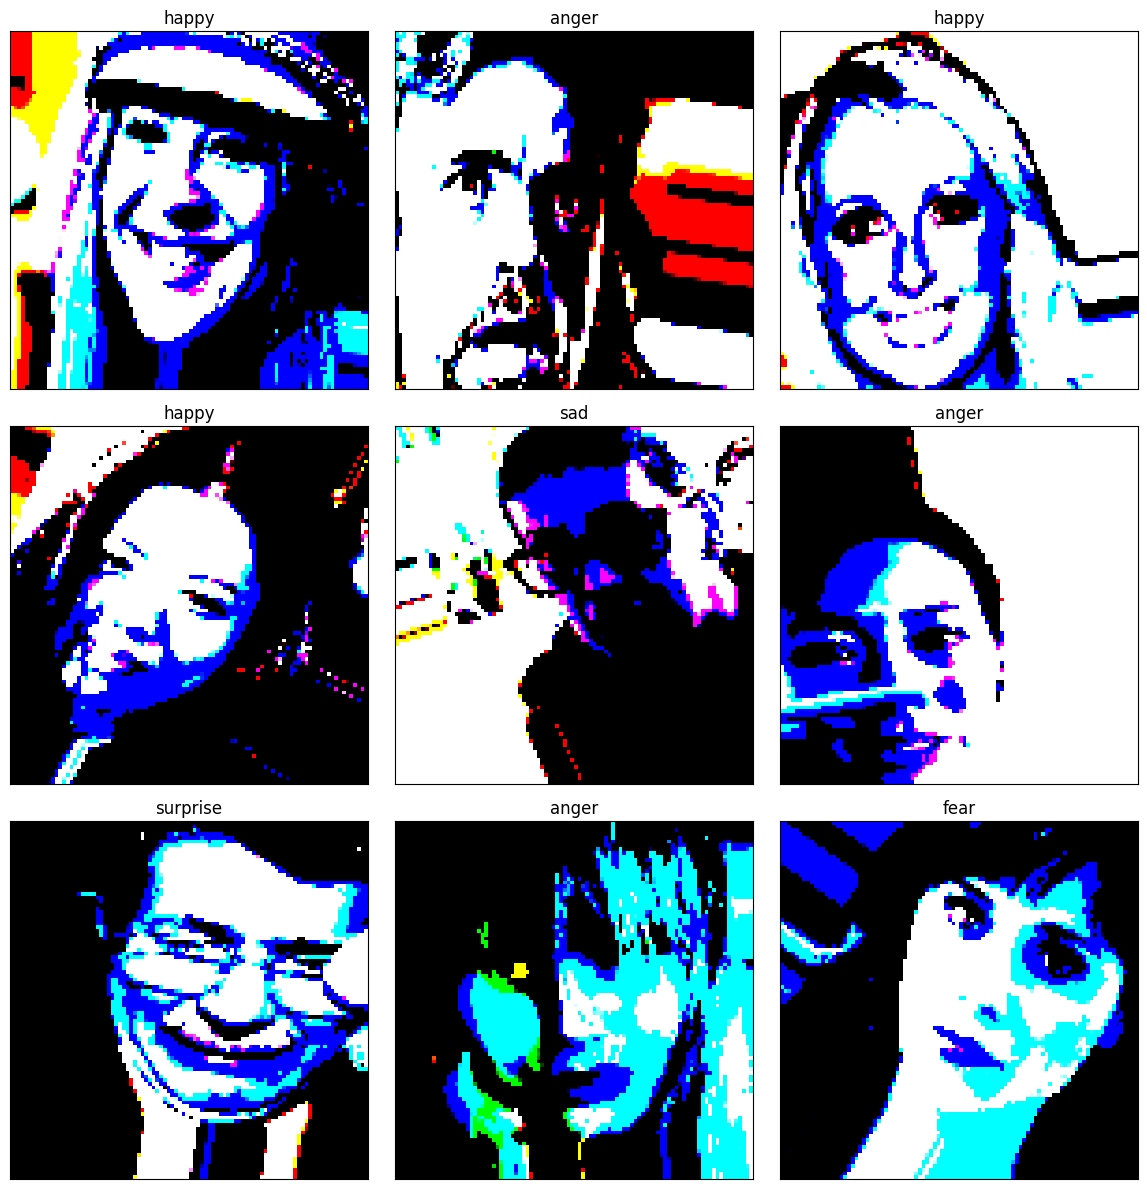

In [17]:
# посмотрим, как выглядят изображения после предобработки VGG19

fig = plt.figure(figsize=(12,12))
for i in range(9):
    idx = random.randint(0, len(features_train))
    fig.add_subplot(3,3, i+1)
    plt.imshow(features_train[idx])
    plt.title(emotions[np.argmax(target_train[idx])])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Обучение и оценка VGG19**

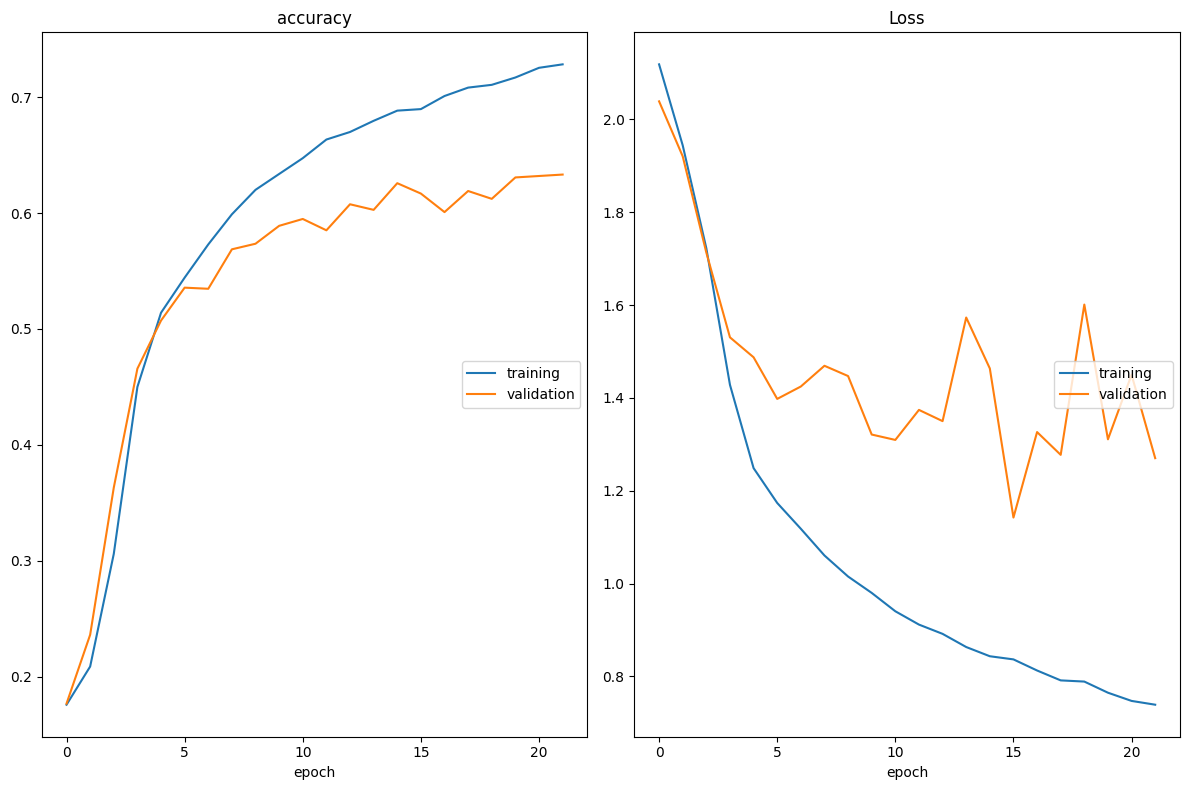

accuracy
	training         	 (min:    0.176, max:    0.728, cur:    0.728)
	validation       	 (min:    0.177, max:    0.633, cur:    0.633)
Loss
	training         	 (min:    0.739, max:    2.119, cur:    0.739)
	validation       	 (min:    1.142, max:    2.039, cur:    1.270)
171/171 [==============================] - 114s 666ms/step - loss: 0.7392 - accuracy: 0.7283 - val_loss: 1.2702 - val_accuracy: 0.6332
Epoch 23/25
 63/171 [==========>...................] - ETA: 56s - loss: 0.7216 - accuracy: 0.7324

In [ ]:
vgg = model_report(tf.keras.applications.VGG19, 'selu', (96, 96, 3), 25)

Результат VGG19 - 63%.

#### DenseNet

**Подготовка данных для DenseNet**

In [ ]:
# импортируем соответствующий предобработчик данных для DenseNet
# готовим выборки для DenseNet

from tensorflow.keras.applications.densenet import preprocess_input
train_data_gen, val_data_gen, features_train, target_train, features_valid, target_valid =\
 data_gen(preprocess_input, 128, (96,96))

Found 21785 images belonging to 8 classes.
Found 7257 images belonging to 8 classes.
(96, 96, 3)


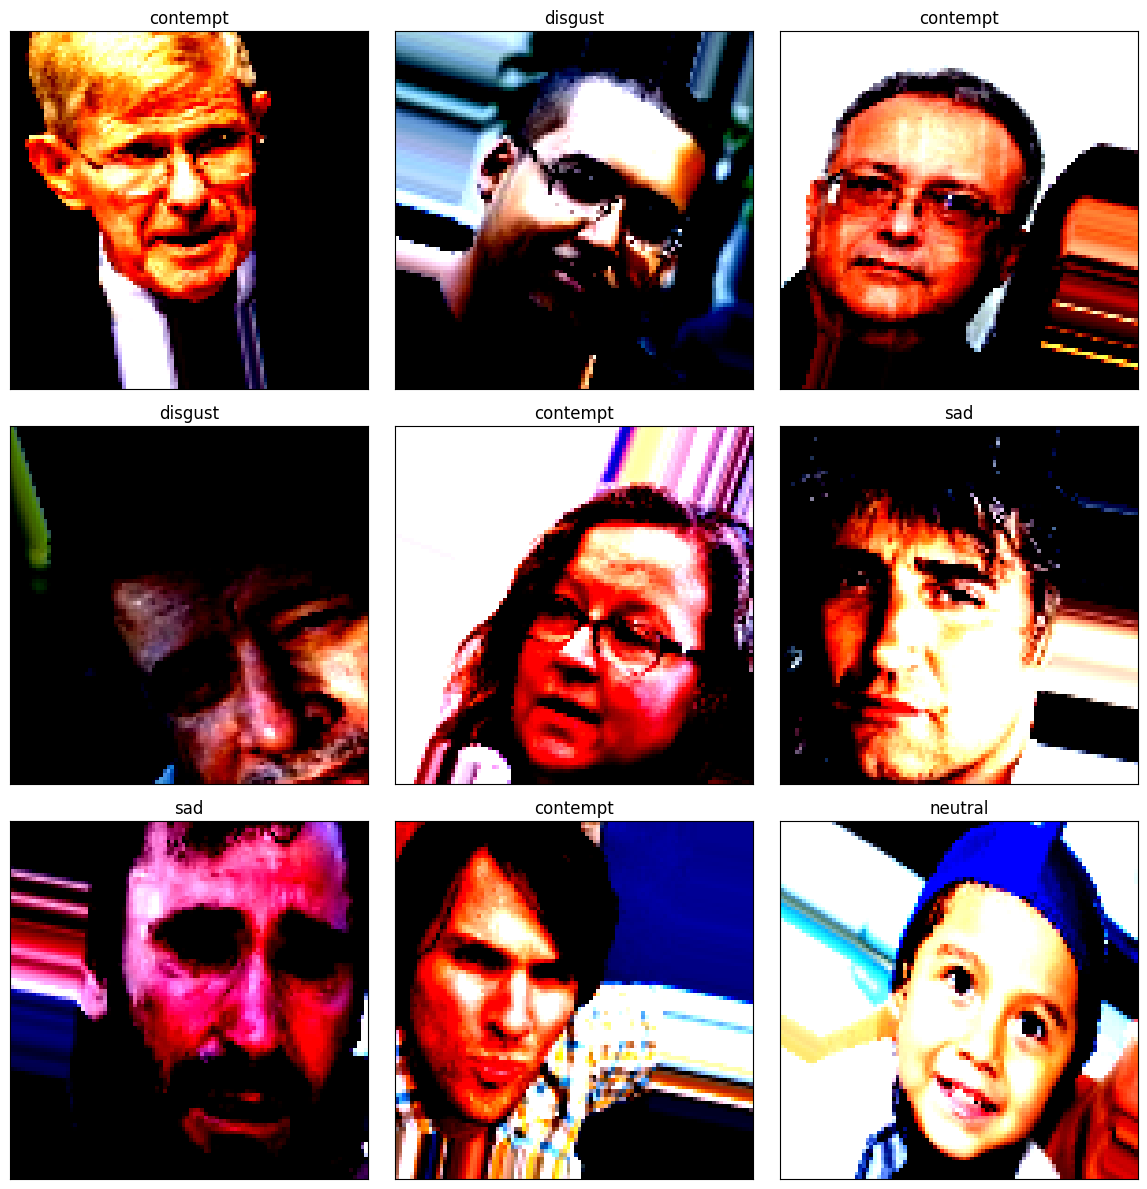

In [ ]:
# посмотрим, как выглядят изображения после предобработки DenseNet

fig = plt.figure(figsize=(12,12))
for i in range(9):
    idx = random.randint(0, len(features_train))
    fig.add_subplot(3,3, i+1)
    plt.imshow(features_train[idx])
    plt.title(emotions[np.argmax(target_train[idx])])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Обучение и оценка DenseNet121**

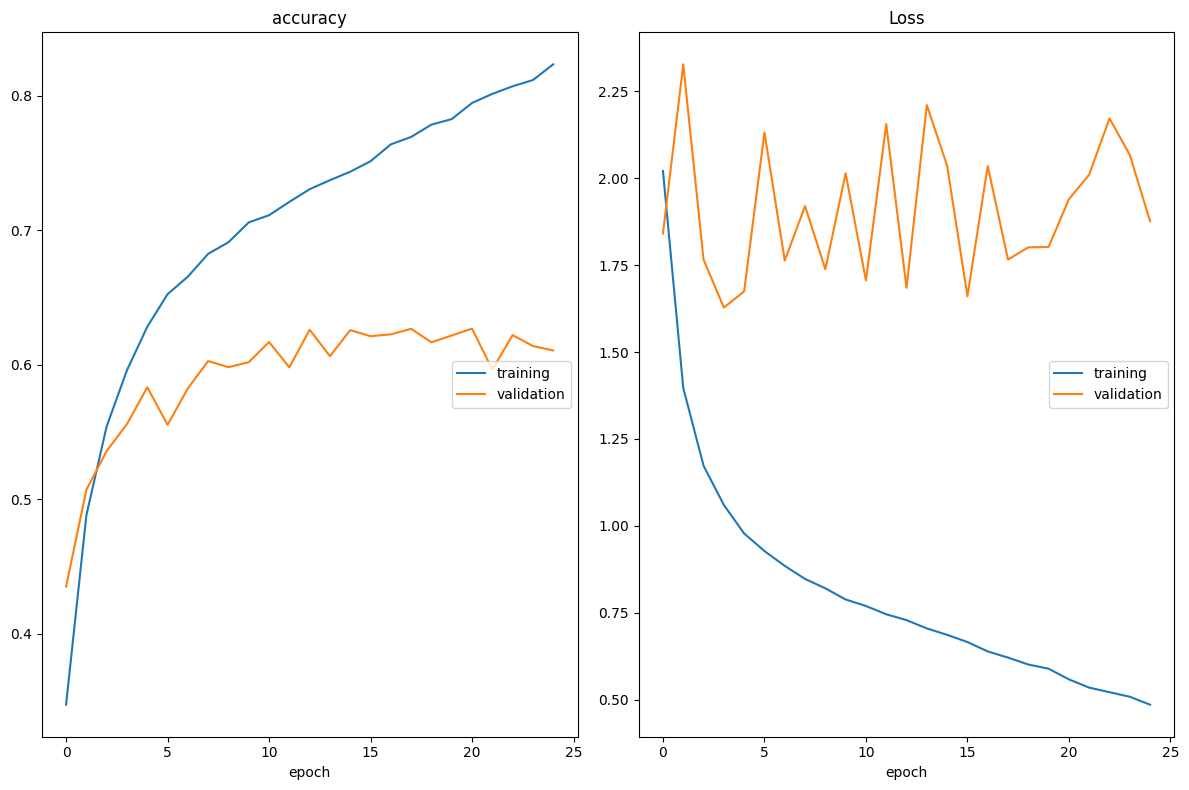

accuracy
	training         	 (min:    0.347, max:    0.823, cur:    0.823)
	validation       	 (min:    0.435, max:    0.627, cur:    0.611)
Loss
	training         	 (min:    0.485, max:    2.021, cur:    0.485)
	validation       	 (min:    1.628, max:    2.328, cur:    1.876)
171/171 [==============================] - 112s 654ms/step - loss: 0.4853 - accuracy: 0.8232 - val_loss: 1.8762 - val_accuracy: 0.6106


In [ ]:
densenet121 = model_report(tf.keras.applications.densenet.DenseNet121, 'selu', (96, 96, 3), 25)

**Обучение и оценка DenseNet169**

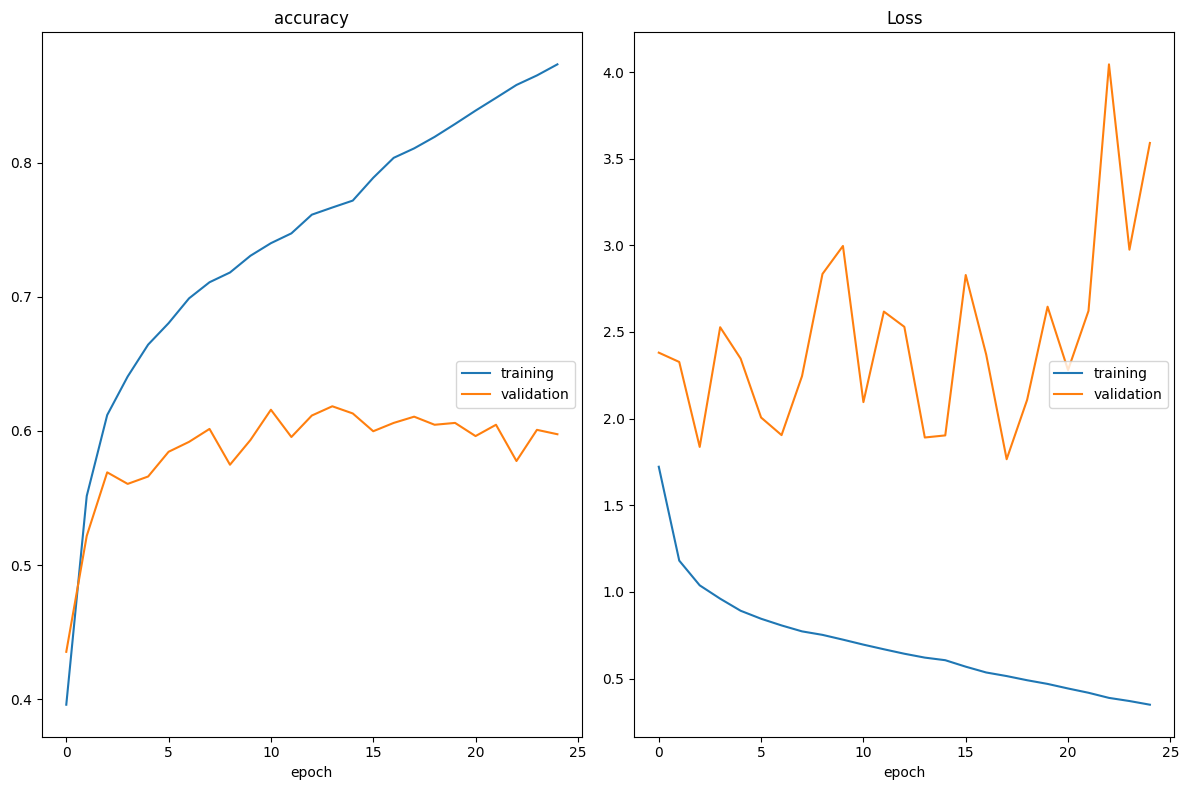

accuracy
	training         	 (min:    0.396, max:    0.873, cur:    0.873)
	validation       	 (min:    0.435, max:    0.618, cur:    0.598)
Loss
	training         	 (min:    0.349, max:    1.722, cur:    0.349)
	validation       	 (min:    1.766, max:    4.044, cur:    3.591)
182/182 [==============================] - 121s 664ms/step - loss: 0.3490 - accuracy: 0.8734 - val_loss: 3.5905 - val_accuracy: 0.5976


In [ ]:
densenet169 = model_report(tf.keras.applications.densenet.DenseNet169, 'selu', (96, 96, 3), 25)

**Обучение и оценка DenseNet201**

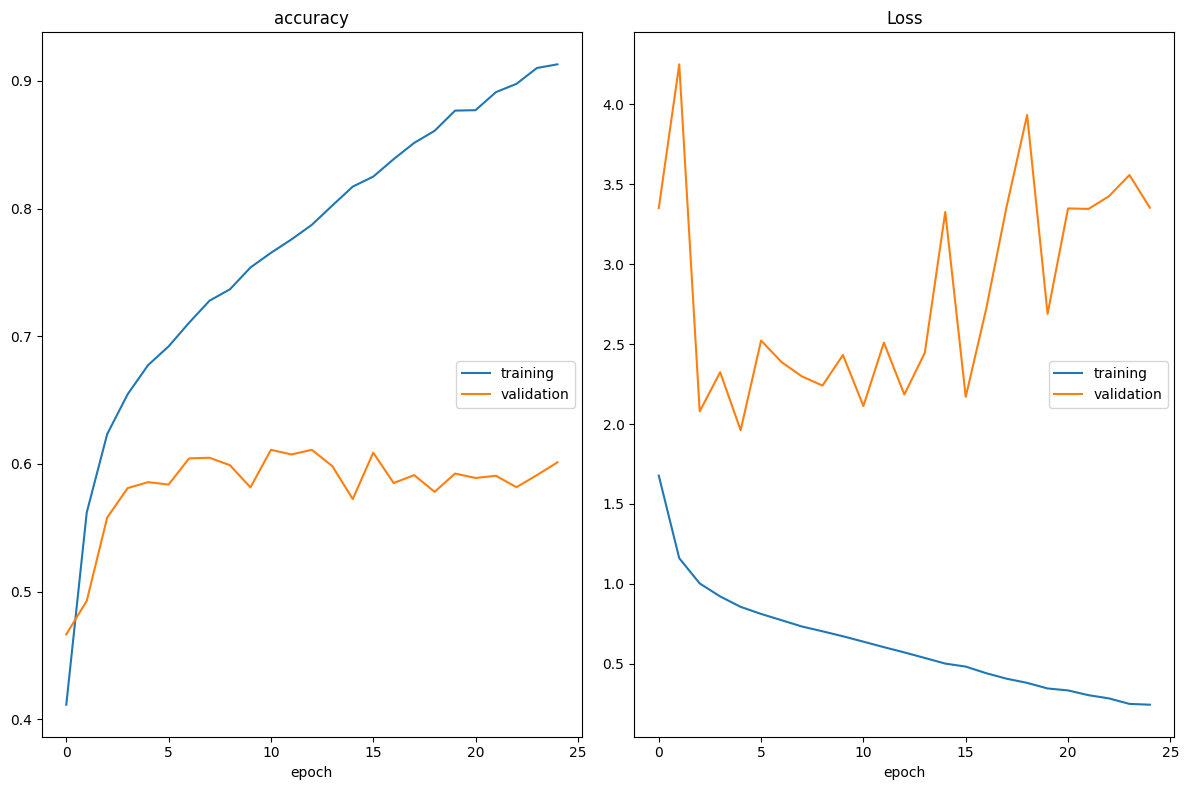

accuracy
	training         	 (min:    0.411, max:    0.913, cur:    0.913)
	validation       	 (min:    0.466, max:    0.611, cur:    0.601)
Loss
	training         	 (min:    0.244, max:    1.677, cur:    0.244)
	validation       	 (min:    1.961, max:    4.251, cur:    3.354)
182/182 [==============================] - 128s 704ms/step - loss: 0.2436 - accuracy: 0.9130 - val_loss: 3.3537 - val_accuracy: 0.6012


In [ ]:
densenet201 = model_report(tf.keras.applications.densenet.DenseNet201, 'selu', (96, 96, 3), 25)

Результаты DenseNet121/169/201 не более 61%.

#### ResNet50

**Подготовка данных для ResNet50**

In [18]:
# импортируем соответствующий предобработчик данных для ResNet50
# готовим выборки для ResNet50

from tensorflow.keras.applications.resnet50 import preprocess_input
train_data_gen, val_data_gen, features_train, target_train, features_valid, target_valid =\
 data_gen(preprocess_input, 128, (96,96))

Found 21785 images belonging to 8 classes.
Found 7257 images belonging to 8 classes.
(96, 96, 3)


In [ ]:
val_data_gen.class_indices

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7}

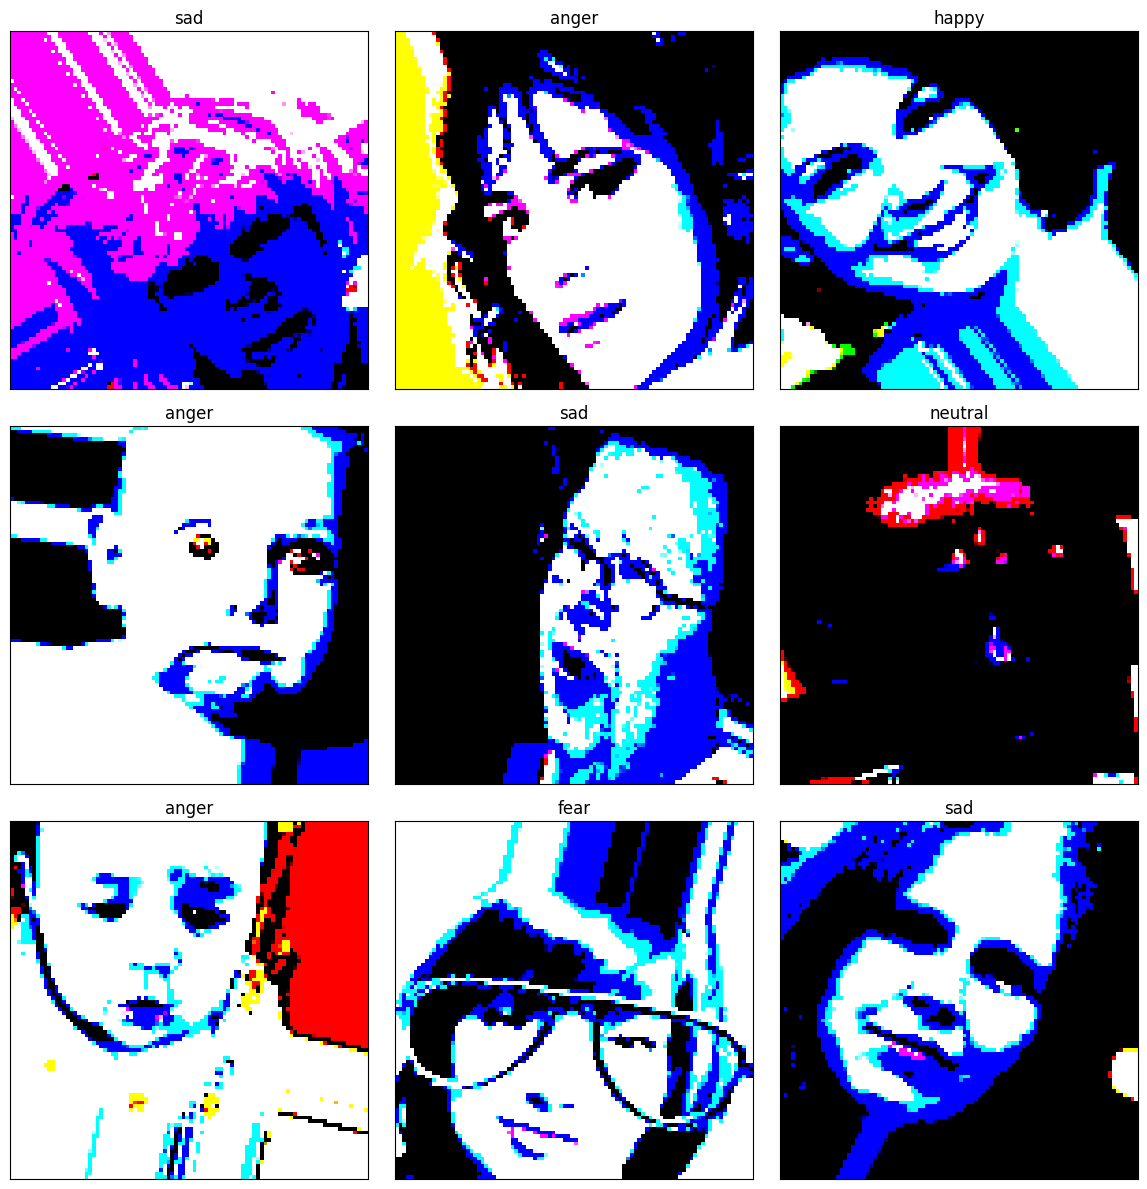

In [24]:
# посмотрим, как выглядят изображения после предобработки ResNet50

fig = plt.figure(figsize=(12,12))
for i in range(9):
    idx = random.randint(0, len(features_train))
    fig.add_subplot(3,3, i+1)
    plt.imshow(features_train[idx])
    plt.title(emotions[np.argmax(target_train[idx])])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

**Обучение и оценка ResNet50**

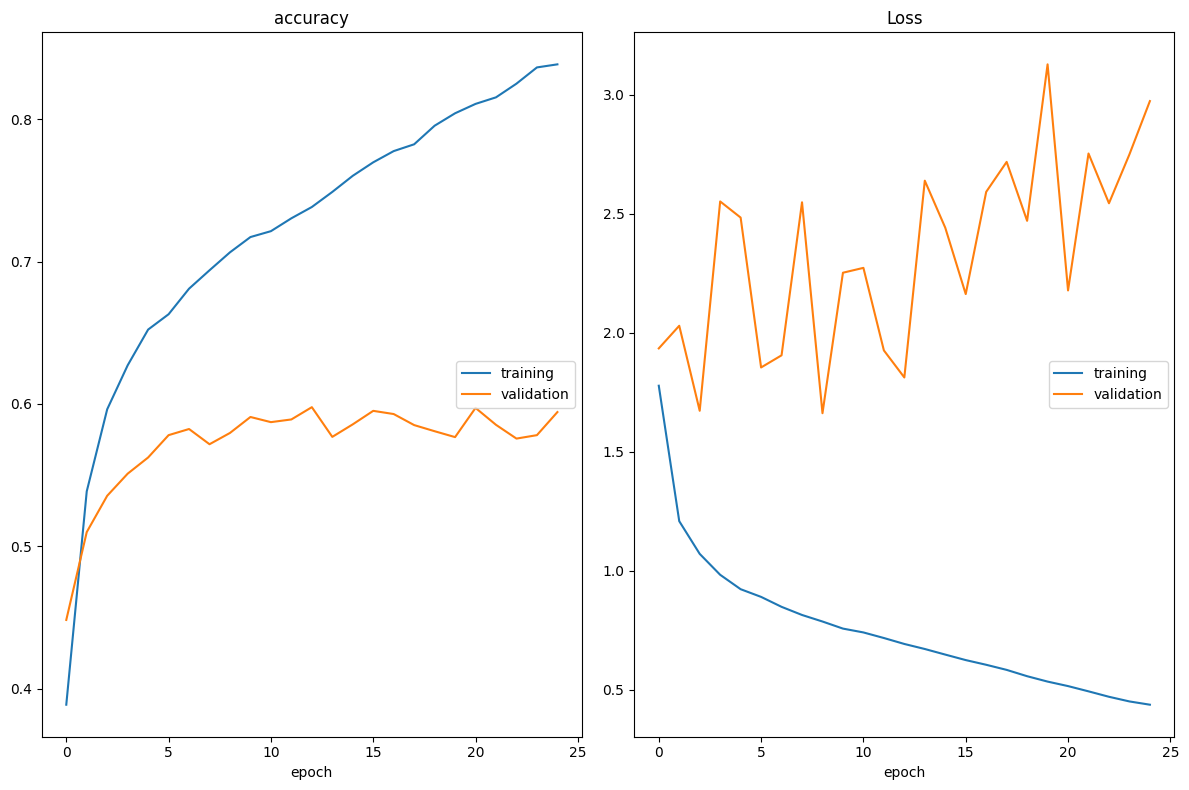

accuracy
	training         	 (min:    0.389, max:    0.838, cur:    0.838)
	validation       	 (min:    0.448, max:    0.598, cur:    0.594)
Loss
	training         	 (min:    0.437, max:    1.777, cur:    0.437)
	validation       	 (min:    1.662, max:    3.127, cur:    2.973)
182/182 [==============================] - 120s 656ms/step - loss: 0.4374 - accuracy: 0.8384 - val_loss: 2.9732 - val_accuracy: 0.5943


In [ ]:
resnet = model_report(tf.keras.applications.resnet50.ResNet50, 'selu', (96, 96, 3), 25)

Результат 59%.

In [ ]:
# сохраним лучшую модель для дальнейшего теста

model_25_selu.save("/content/gdrive/MyDrive/Эмоции/model.h5")

**Вывод**

На валидации лучше всего себя показали именно ручные архитектуры моделей: на 25 эпохах с функциями активации selu и relu - по 66%. На 40 эпохах с функцией акутивации selu - 65%. Модели на базе предобученных готовых архитектур справились чуть хуже: VGG19 - 63%,  DenseNet - 59-61%, ResNet50 - 59%.

## Общий вывод

Для решения задачи мы обучили несколько вариантов ручных архитектур моделей и несколько предобученных готовых архитектур. Для упрощения процесса подготовили ряд функций (для инициализации моделей, обучения и оценки качества моделей, подготовки выборок). На валидационных выборках лучше всего справились ручные архитектуры моделей: на 25 эпохах с функциями активации selu и relu - по 66%. На 40 эпохах с функцией акутивации selu - 65%. Модели на базе предобученных готовых архитектур справились чуть хуже: VGG19 - 63%,  DenseNet - 59-61%, ResNet50 - 59%. Для дальнейшего использования модели на реальных изображениях сохранили ручную модель обученную на 25 эпохах с функцией активации selu.